In [1]:
import pandas as pd
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import copy

# Load and transform training and test data

In [12]:
df_train = pd.read_csv('adult.data', header = None)
X_train_orig = df_train.drop(df_train.columns[[14]], axis=1, inplace=False)
Y_train_orig = df_train[[14]]
df_test = pd.read_csv('adult.test', header = None)
X_test_orig = df_test.drop(df.columns[[14]], axis=1, inplace=False)
Y_test_orig = df_test[[14]]
dataset = pd.concat(objs=[X_train_orig, X_test_orig], axis = 0)
data = pd.get_dummies(dataset)              # get one hot encoding
X_train = copy.copy(data[:len(X_train_orig)])
X_test = copy.copy(data[len(X_train_orig):])
Y_train = pd.get_dummies(Y_train_orig)      # get one hot encoding
Y_test = pd.get_dummies(Y_test_orig)        # get one hot encoding
print "X train shape = " + str(X_train.shape)
print "Y train shape = " + str(Y_train.shape)
print "X test shape = " + str(X_test.shape)
print "Y test  shape = " + str(Y_test.shape)

X train shape = (32561, 108)
Y train shape = (32561, 2)
X test shape = (16281, 108)
Y test  shape = (16281, 2)


# Review one hot encoding

In [3]:
Y_train_orig.head()

,14
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [4]:
Y_train.head()

,14_ <=50K,14_ >50K
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


# Create placeholders for X and Y

In [5]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, [n_y, None], name = "Y")
    return X, Y

# Initialize all neural network parameters

In [14]:
def initialize_parameters(num_features, num_layers):
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
    num_neurons = []
    num_neurons.append(0)
    W = []
    W.append(0)
    b = []
    b.append(0)
    for i in range(1, num_layers + 1):
        if i == num_layers:
            num_neurons.append(2)         # the last softmax layer has only two neurons for two classes
        else:
            num_neurons.append(10)
        if i == 1:
            arg2 = num_features
        else:
            arg2 = num_neurons[i - 1]
        W.append(tf.get_variable("W" + str(i), [num_neurons[i], arg2], 
                               initializer = tf.contrib.layers.xavier_initializer(seed = 1)))
        b.append(tf.get_variable("b" + str(i), [num_neurons[i] , 1], initializer = tf.zeros_initializer()))

    parameters = {}
    for i in range(1, num_layers + 1):
        parameters["W" + str(i)] = W[i]
        parameters["b" + str(i)] = b[i]
    return parameters

# Forward propagation implementation for all layers

In [15]:
def forward_propagation(X, parameters, num_layers):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W = []
    W.append(0)
    b = []
    b.append(0)
    Z = []
    Z.append(0)
    A = []
    A.append(X)
    for i in range(1, num_layers):
        W.append(parameters["W" + str(i)])
        b.append(parameters["b" + str(i)])
        Z.append(tf.add(tf.matmul(W[i], A[i - 1]), b[i]))
        A.append(tf.nn.relu(Z[i]))
                                        
    Z = tf.add(tf.matmul(parameters["W" + str(num_layers)], A[num_layers - 1]), parameters["b" + str(num_layers)])
            # last layer computes only z and no A
    
    return Z

In [16]:
def compute_cost(Z, Y):
    """
    Computes the cost
    
    Arguments:
    Z -- output of forward propagation (output of the last LINEAR unit)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

# Build the model using all the tensors defined above

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 1000, print_cost = True, num_layers = 5):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(X_train.shape[0], num_layers)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X, parameters, num_layers)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
                
            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

# Train and evaluate the built model using above loaded data

Cost after epoch 0: 932.746216
Cost after epoch 100: 102.746140


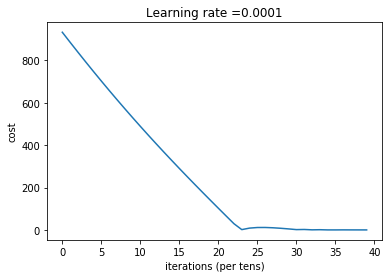

Parameters have been trained!
('Train Accuracy:', 0.77832377)
('Test Accuracy:', 0.78164732)


In [13]:
parameters = model(X_train.T, Y_train.T, X_test.T, Y_test.T, num_epochs = 200)

# Exercise: Train 4 class classifier (automobile, bird,  cat and dog), compute and compare accuracy